In [43]:
import statsmodels
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

Importing data
- Check to see that DataFrame elec has two columns ```date``` and ```elec```
- The variable ```elec``` is electricity retail sales to the residential sector in the US in million kilowatt hours.
- The sample is monthly and covers the period from 1973M1 to 2011M12 but  weuse the sample up to 2010M12

In [27]:
elec = pd.read_csv('data/elec.csv')
elec.index = pd.date_range(start='1973-01-01', periods= elec.shape[0], freq='M')

# Define start and end date of sample
start = '1973-01-01'
end = '2011-01-01' 

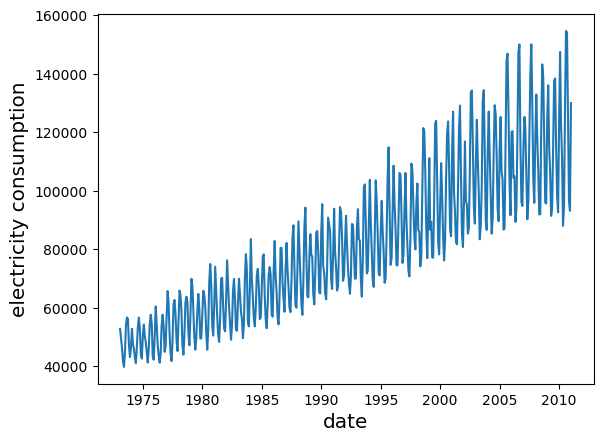

In [28]:
#plotting original
plt.plot(elec['elec'][start:end])
ax = plt.gca()
ax.set_ylabel('electricity consumption', fontsize = 'x-large')
ax.set_xlabel('date', fontsize = 'x-large')
plt.show()

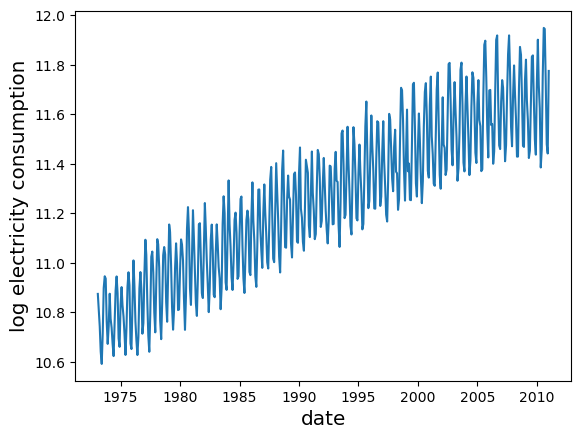

In [29]:
#plotting log of electricity consumption
elec['logelec'] = np.log(elec['elec'])
plt.plot(elec['logelec'][start:end])
ax = plt.gca()
ax.set_ylabel('log electricity consumption', fontsize = 'x-large')
ax.set_xlabel('date', fontsize = 'x-large')
plt.show()

In [30]:
# Generate constant and time variables
elec['constant'] = 1
elec['time'] = np.arange(elec.shape[0])+1

# Linear trend model
Y = elec['logelec'][start:end]
X_linear = elec[['constant','time']][start:end]

# sm.OLS(Y,X_quadratic) regresses Y on regressors in X_quadratic
result_linear = sm.OLS(Y,X_linear, missing='drop').fit()
print(result_linear.summary())

                            OLS Regression Results                            
Dep. Variable:                logelec   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     1665.
Date:                Thu, 29 Jun 2023   Prob (F-statistic):          5.69e-154
Time:                        14:31:12   Log-Likelihood:                 232.59
No. Observations:                 456   AIC:                            -461.2
Df Residuals:                     454   BIC:                            -452.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant      10.7756      0.014    788.826      0.0

In [31]:
# Generate time^2 values
elec['time2'] = elec['time']**2

# Quadratic trend model
X_quadratic = elec[['constant','time','time2']][start:end]

# sm.OLS(Y,X_quadratic) regresses Y on regressors in X_quadratic
result_quadratic = sm.OLS(Y,X_quadratic, missing='drop').fit()
print(result_quadratic.summary())

                            OLS Regression Results                            
Dep. Variable:                logelec   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     845.9
Date:                Thu, 29 Jun 2023   Prob (F-statistic):          1.11e-153
Time:                        14:31:12   Log-Likelihood:                 235.88
No. Observations:                 456   AIC:                            -465.8
Df Residuals:                     453   BIC:                            -453.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant      10.7365      0.020    525.738      0.0

We will choose the quadratic model
- The time^2 variable is statistically significant
- The quadratic model gives a better fit

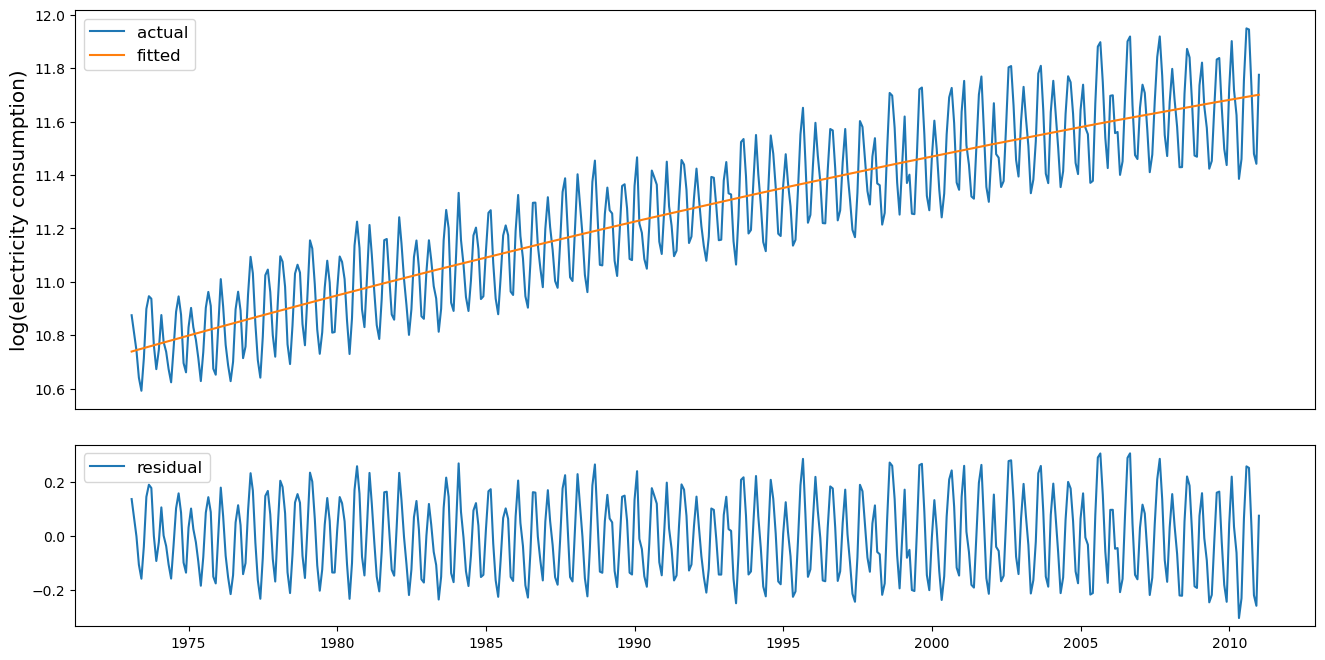

In [32]:
#residual plot
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[:2])
ax2 = fig.add_subplot(gs[2], sharex=ax1)

# Plots dependent variable Y and fitted values in the upper panel
ax1.plot(Y, label = 'actual')
ax1.plot(result_quadratic.fittedvalues, label = 'fitted')

# Plots residuals in the lower panel
ax2.plot(result_quadratic.resid, '-',label='residual')

ax1.tick_params(bottom=False, labelbottom=False, left=True, labelleft=True)
ax1.set_ylabel('log(electricity consumption)', fontsize = 'x-large')

ax1.legend(loc='upper left', fontsize = 'large')
ax2.legend(loc='upper left', fontsize = 'large')
plt.show()

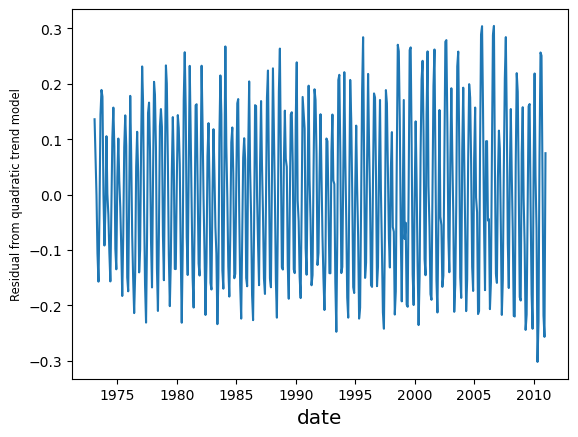

In [33]:
# only residuals
plt.plot(result_quadratic.resid)
ax = plt.gca()
ax.set_ylabel('Residual from quadratic trend model', fontsize = 'small')
ax.set_xlabel('date', fontsize = 'x-large')
plt.show()

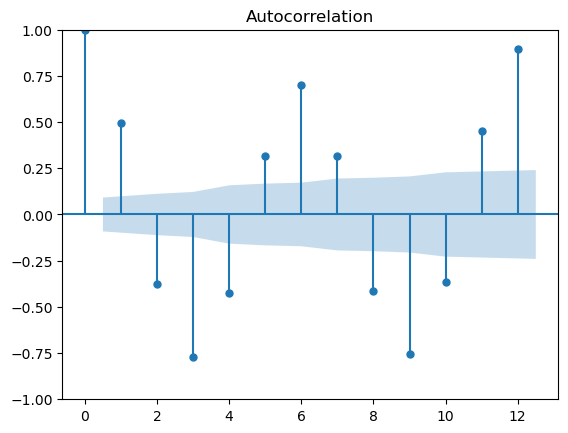

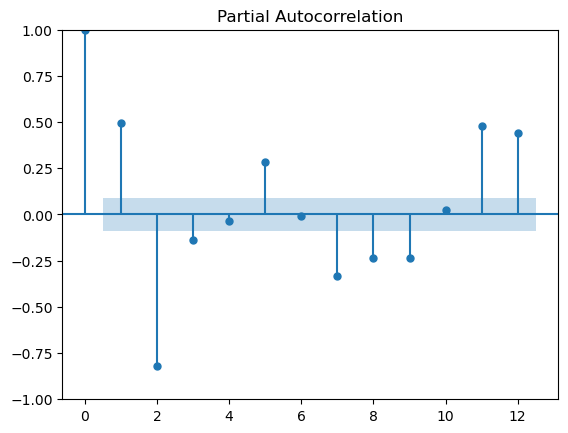

In [34]:
#correlogram
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(result_quadratic.resid, lags=12)
plot_pacf(result_quadratic.resid, lags=12)
plt.show()

The pacf shows that there are seasonal patterns present in the data. Lets estimate a model with a trend and a full set of dummy variables.

In [35]:
# Generate dummy variables for every month
elec['month'] = pd.DatetimeIndex(elec.index).month
dummy = pd.get_dummies(elec['month'], prefix='m')

# Merge the dummies variables with liquor sales data and obtain a new DataFrame named "df"
df = pd.concat([elec,dummy], axis=1)

# Define the new independent variables for this regression with both trend and seasonal components
Y = df['logelec'][start:end]
X_season = df[['time', 'time2', 'm_1','m_2','m_3','m_4','m_5','m_6','m_7','m_8','m_9','m_10','m_11','m_12']][start:end]

result_season = sm.OLS(Y, X_season, missing='drop').fit()
print(result_season.summary())

                            OLS Regression Results                            
Dep. Variable:                logelec   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1287.
Date:                Thu, 29 Jun 2023   Prob (F-statistic):               0.00
Time:                        14:31:12   Log-Likelihood:                 715.84
No. Observations:                 456   AIC:                            -1404.
Df Residuals:                     442   BIC:                            -1346.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
time           0.0026   7.29e-05     36.063      0.0

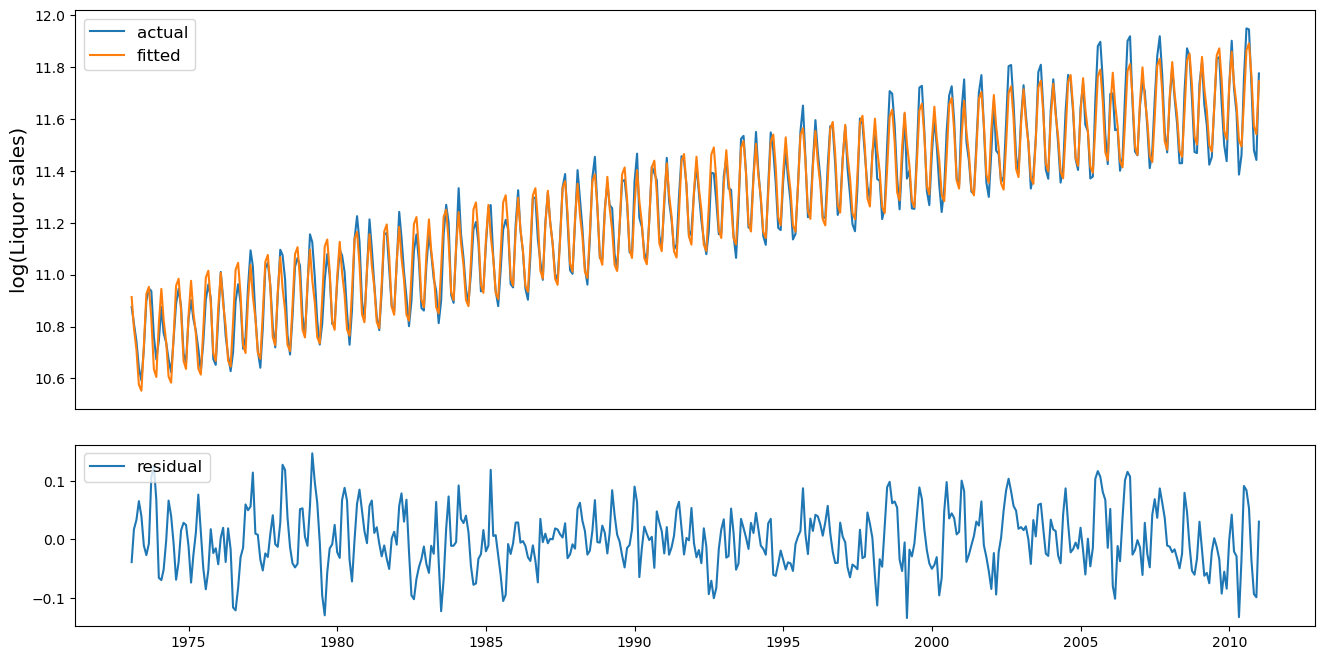

In [36]:
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[:2])
ax2 = fig.add_subplot(gs[2], sharex=ax1)

ax1.plot(Y, label = 'actual')
ax1.plot(result_season.fittedvalues, label = 'fitted')

ax2.plot(result_season.resid, '-',label='residual')

ax1.tick_params(bottom=False, labelbottom=False, left=True, labelleft=True)
ax1.set_ylabel('log(Liquor sales)', fontsize = 'x-large')

ax1.legend(loc='upper left', fontsize = 'large')
ax2.legend(loc='upper left', fontsize = 'large')
plt.show()

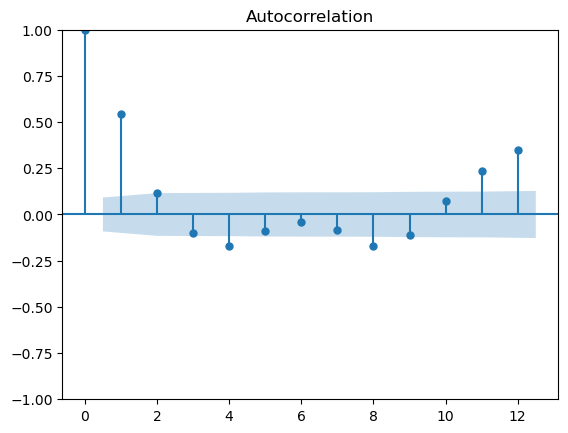

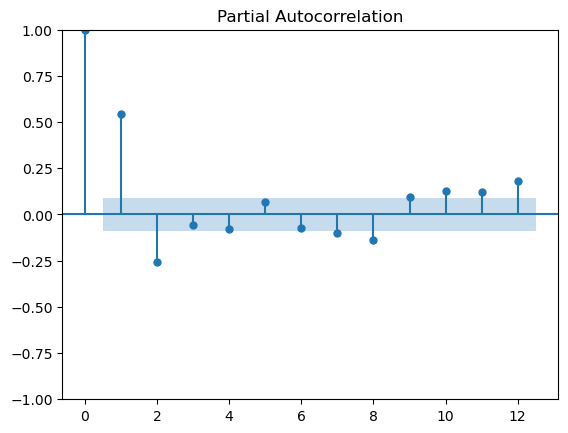

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(result_season.resid, lags=12)
plot_pacf(result_season.resid, lags=12)
plt.show()

According to the correlograms there is some cycles/serial correlation. Let's estimate a couple ARMA(𝑝, 𝑞) model with 𝑝=0,1,2,3 and 𝑞=0,1,2,3 except  𝑝=𝑞=0 and report SICs. This will help us decide which lag orders to use.

In [38]:
X1 = df[['time', 'time2', 'm_1','m_2','m_3','m_4','m_5','m_6','m_7','m_8','m_9','m_10','m_11','m_12']][start:end]
#function to find sic of an arma model
def get_sic(p, q):
    # fit arima model
    model = ARIMA(Y, order=(p, 0, q), exog=X1, trend='n').fit()
    return model.bic

In [39]:
#ConvergenceWarning: Maximum Likelihood optimization failed to converge 
#not best practice but it is what it is
import warnings
warnings.filterwarnings("ignore")

sics = {}
for p in range(4):
    for q in range(4):
        if p!=0 or q!=0:
          sics[(p, q)] = get_sic(p,q)

# Print the SIC values for all the estimated models
for pq, sic in sics.items():
    if sic < min:
        min = sic
    print(f"ARMA{pq}: SIC = {sic:.2f}")


ARMA(0, 1): SIC = -1499.70
ARMA(0, 2): SIC = -1511.09
ARMA(0, 3): SIC = -1505.04
ARMA(1, 0): SIC = -1492.47
ARMA(1, 1): SIC = -1512.22
ARMA(1, 2): SIC = -1505.93
ARMA(1, 3): SIC = -1499.19
ARMA(2, 0): SIC = -1518.24
ARMA(2, 1): SIC = -1514.34
ARMA(2, 2): SIC = -1508.73
ARMA(2, 3): SIC = -1500.60
ARMA(3, 0): SIC = -1513.63
ARMA(3, 1): SIC = -1505.52
ARMA(3, 2): SIC = -1260.88
ARMA(3, 3): SIC = -1498.56
-1518.2398651321416


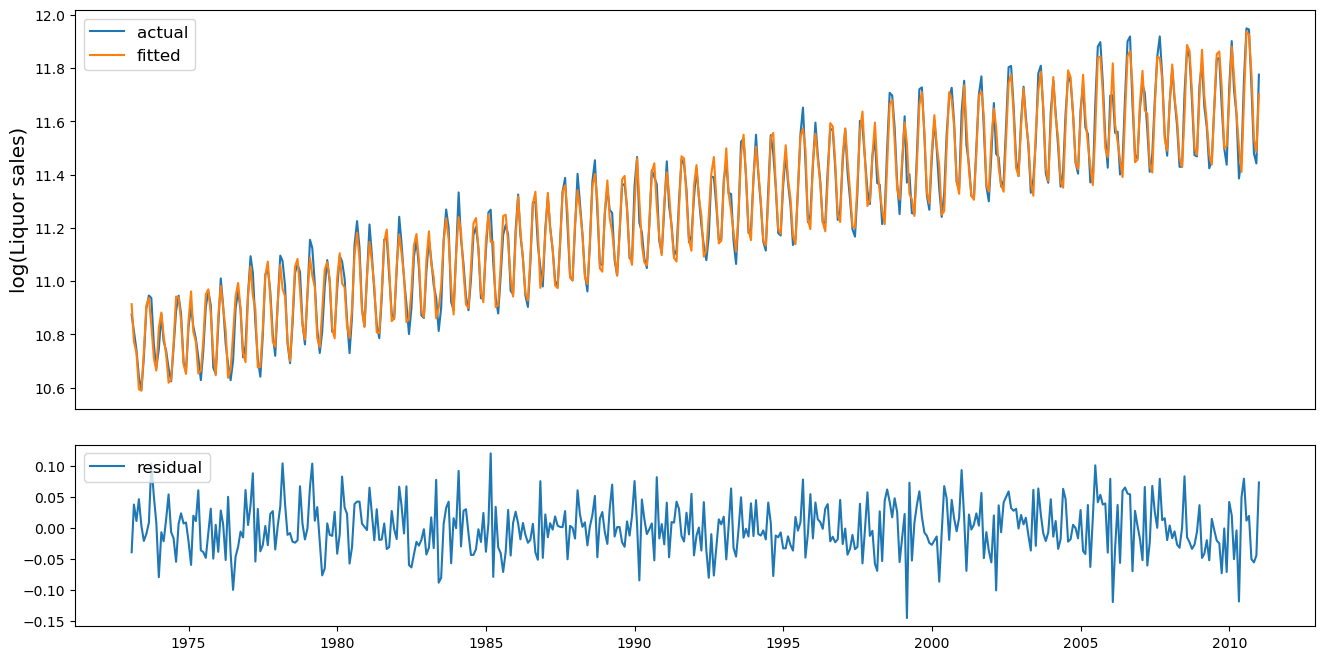

In [40]:
#model 
result_arma = ARIMA(Y, order=(2, 0, 0), exog=X1, trend='n').fit()

#plot
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[:2])
ax2 = fig.add_subplot(gs[2], sharex=ax1)

ax1.plot(Y, label = 'actual')
ax1.plot(result_arma.fittedvalues, label = 'fitted')

ax2.plot(result_arma.resid, '-',label='residual')

ax1.tick_params(bottom=False, labelbottom=False, left=True, labelleft=True)
ax1.set_ylabel('log(Liquor sales)', fontsize = 'x-large')

ax1.legend(loc='upper left', fontsize = 'large')
ax2.legend(loc='upper left', fontsize = 'large')

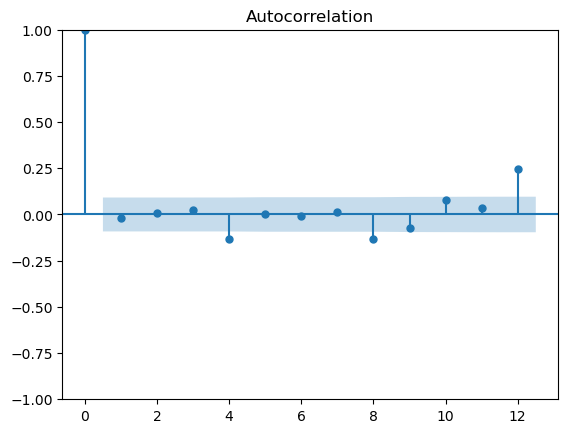

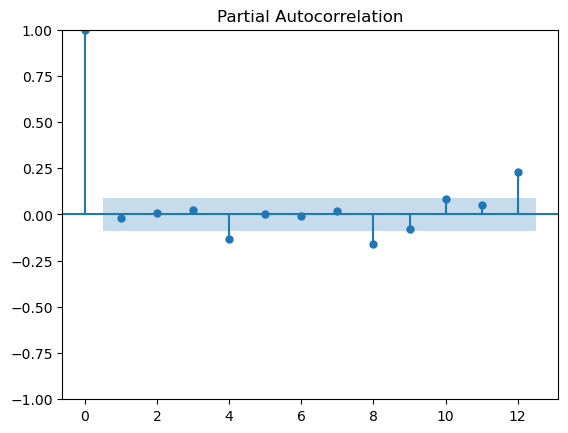

In [41]:
plot_acf(result_arma.resid, lags=12)
plot_pacf(result_arma.resid, lags=12)
plt.show()

Our model doesn't look too bad. Let's try to forecast the level of electricity retail sales as well as the 95% confidence intervals

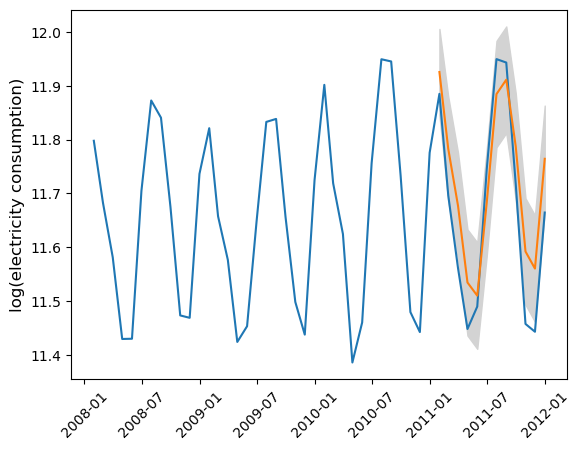

In [42]:
# Define the start and end(exclusive) date of our forecasting period
forecast_start = '2011-01-01'
forecast_end = '2012-01-01'

X_exog = df[['time', 'time2', 'm_1','m_2','m_3','m_4','m_5','m_6','m_7','m_8','m_9','m_10','m_11','m_12']][forecast_start:forecast_end]
forecast = result_arma.get_forecast(12, exog=X_exog)
mean_forecast = forecast.predicted_mean
confidence_interval = forecast.conf_int()


plt.plot(df['logelec']['2008-01-01':'2012-01-01'])
plt.plot(df.index[-12:], mean_forecast.values)
ax = plt.gca()
ax.tick_params(axis = 'x', rotation = 45)
ax.set_ylabel('log(electricity consumption)', fontsize = 'large')

# Shade confidence interval
plt.fill_between(df.index[-12:], confidence_interval['lower logelec'], confidence_interval['upper logelec'], color='lightgrey')
plt.show()